In [5]:
%%capture
!pip install contractions  datasets

import warnings
warnings.filterwarnings("ignore")

In [4]:
!pip uninstall -y torch torchtext torchaudio
!pip install torch torchtext torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Found existing installation: torch 2.2.1
Uninstalling torch-2.2.1:
  Successfully uninstalled torch-2.2.1
Found existing installation: torchtext 0.17.2
Uninstalling torchtext-0.17.2:
  Successfully uninstalled torchtext-0.17.2
Found existing installation: torchaudio 2.2.1
Uninstalling torchaudio-2.2.1:
  Successfully uninstalled torchaudio-2.2.1


You can safely remove it manually.
You can safely remove it manually.


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.6.0%2Bcu118-cp312-cp312-win_amd64.whl.metadata (28 kB)
  Using cached https://download.pytorch.org/whl/torchtext-0.16.2%2Bcpu-cp312-cp312-win_amd64.whl (1.9 MB)
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.6.0%2Bcu118-cp312-cp312-win_amd64.whl.metadata (6.8 kB)
  Using cached https://download.pytorch.org/whl/cu118/torch-2.2.0%2Bcu118-cp312-cp312-win_amd64.whl (2704.2 MB)
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.21.0%2Bcu118-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.20.1%2Bcu118-cp312-cp312-win_amd64.whl (5.3 MB)
  Using cached h

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [6]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)

2.2.1+cpu
False
None


In [ ]:
!pip uninstall torch -y

In [ ]:
!pip install torch==2.0.0+cu120

ERROR: Could not find a version that satisfies the requirement torch==2.2.0+cu116 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0)
ERROR: No matching distribution found for torch==2.2.0+cu116


In [7]:
!pip install pyarabic

Defaulting to user installation because normal site-packages is not writeable


In [11]:
import os
import math
import random
import re
import time
import unicodedata

import nltk
import numpy as np
import pandas as pd

import pyarabic.araby as araby
import contractions
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.utils.data import Dataset

from torchtext.vocab import build_vocab_from_iterator

from tqdm import tqdm
tqdm.pandas()

In [12]:
# %%script echo skipping
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
print(torch.cuda.get_device_name(0))
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb=64'

cpu


AssertionError: Torch not compiled with CUDA enabled

In [13]:
#https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

nltk.download('punkt')
def tokenize_ar(text):
    return [tok for tok in nltk.tokenize.wordpunct_tokenize(unicodeToAscii(text))]

def tokenize_en(text):
    return [tok for tok in nltk.tokenize.wordpunct_tokenize(unicodeToAscii(text))]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shaiiikh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
from datasets import load_dataset

# Add trust_remote_code=True to allow custom code execution
dataset = load_dataset('Helsinki-NLP/tatoeba_mt', 'ara-eng', trust_remote_code=True)


tatoeba-test.ara-eng.tsv:   0%|          | 0.00/938k [00:00<?, ?B/s]

tatoeba-dev.ara-eng.tsv:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/10304 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/19528 [00:00<?, ? examples/s]

In [16]:
dataset

DatasetDict({
    test: Dataset({
        features: ['sourceLang', 'targetlang', 'sourceString', 'targetString'],
        num_rows: 10304
    })
    validation: Dataset({
        features: ['sourceLang', 'targetlang', 'sourceString', 'targetString'],
        num_rows: 19528
    })
})

In [17]:
df, val = dataset['test'], dataset['validation']
df, val = pd.DataFrame(df), pd.DataFrame(val)
df = pd.concat([df, val], ignore_index=True)
df = df[df['sourceLang'] == 'ara']
df = df.drop(columns=['sourceLang', 'targetlang'])
df = df.rename(columns={'sourceString': 'ar', 'targetString': 'en'})
df = df.reset_index(drop=True)

df.sample(n=5)

,ar,en
22781,لقد فعل ذلك مراراً وتكراراً.,He's done that again and again.
27053,وافق سامي.,Sami agreed.
14865,بإمكان جاك تحدث الفرنسية.,Jack can speak French.
4878,عليك أخذ استراحة.,You need to take a break.
4900,عليك أن تدرس جاهداً.,You must study hard.


In [18]:
def preprocess_ar(text):
    text = araby.strip_diacritics(text).strip() # Remove diacritics
    text = re.sub(r'[a-zA-Z]', '', text) # Remove English letters
    text = re.sub(r'\s+', ' ', text).strip() # Trim multiple whitespaces to one
    text = re.sub(r'[_|\d+|\\|\-|؛|،|,|\[|\]|\(|\)|\"|/|%|!|,|.|:|♪|«|»|}|{|*|#]+', '', text) # Remove special characters and digits
    return text

def preprocess_en(text):
    text = text.lower()
    text = contractions.fix(text) # Fix contractions
    text = re.sub(r'[\u0600-\u06FF]', '', text) # Remove Arabic letters
    text = re.sub(r'\s+', ' ', text).strip() # Trim multiple whitespaces to one
    text = re.sub(r'[_|\d+|\\|\-|؛|،|,|\[|\]|\(|\)|\"|/|%|!|,|.|:|♪|«|»|}|{|*|#]+', '', text) # Remove special characters and digits
    return text

In [19]:
df['ar'] = df['ar'].progress_apply(preprocess_ar)
df['en'] = df['en'].progress_apply(preprocess_en)

df = df.dropna()
df = df.replace('', pd.NA).dropna()
df = df.replace(' ', pd.NA).dropna()
df = df.reset_index(drop=True)

100%|██████████| 27889/27889 [00:00<00:00, 64687.73it/s]


In [20]:
train, val, test = np.split(df.sample(frac=1, random_state=42),
                                [int(.9*len(df)), int(.95*len(df))])

del df
print(train.shape, val.shape, test.shape, sep='\n')

(25100, 2)
(1394, 2)
(1395, 2)


In [21]:
def yield_tokens(data_iter, src=True):
    for text in data_iter:
        if src:
            yield tokenize_ar(text)
        else:
            yield tokenize_en(text)

src_vocab = build_vocab_from_iterator(yield_tokens(iter(train['ar'])),
                                      min_freq=2,
                                      specials=[""])
src_vocab.set_default_index(src_vocab[""])

trg_vocab = build_vocab_from_iterator(yield_tokens(iter(train['en']),src=False),
                                      min_freq=2,
                                      specials=[""])
trg_vocab.set_default_index(trg_vocab[""])

In [22]:
print(len(src_vocab))
print(len(trg_vocab))

9224
4860


In [23]:
import pickle

with open("src_vocab.pkl", "wb") as f:
    pickle.dump(src_vocab, f)

with open("trg_vocab.pkl", "wb") as f:
    pickle.dump(trg_vocab, f)


In [24]:
def preprocess(sequence, vocab, src=True):
    if src:
        tokens = tokenize_ar(sequence.lower())
    else:
        tokens = tokenize_en(sequence.lower())

    sequence = []
    sequence.append(vocab[''])
    sequence.extend([vocab[token] for token in tokens])
    sequence.append(vocab[''])
    sequence = torch.Tensor(sequence)
    return sequence

def collate_fn(data):
    def merge(sequences):
        lengths = [len(seq) for seq in sequences]
        padded_seqs = torch.zeros(len(sequences), max(lengths)).long()
        for i, seq in enumerate(sequences):
            end = lengths[i]
            padded_seqs[i, :end] = seq[:end]
        return padded_seqs, lengths

    data.sort(key=lambda x: len(x[0]), reverse=True)
    src_seqs, trg_seqs = zip(*data)
    src_seqs, src_lengths = merge(src_seqs)
    trg_seqs, trg_lengths = merge(trg_seqs)

    return src_seqs, src_lengths, trg_seqs, trg_lengths

class CustomDataset(Dataset):
    def __init__(self, src, trg, src_vocab, trg_vocab):
        self.src_seqs = src
        self.trg_seqs = trg
        self.num_total_seqs = len(self.src_seqs)
        self.src_vocab= src_vocab
        self.trg_vocab = trg_vocab

    def __getitem__(self, index):
        src_seq = self.src_seqs.iloc[index]
        trg_seq = self.trg_seqs.iloc[index]
        src_seq = preprocess(src_seq, self.src_vocab)
        trg_seq = preprocess(trg_seq, self.trg_vocab, src=False)
        return src_seq, trg_seq

    def __len__(self):
        return self.num_total_seqs

In [25]:
def get_loader(src, trg, src_vocab, trg_vocab, batch_size=64):
    dataset = CustomDataset(src, trg, src_vocab, trg_vocab)
    data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              collate_fn=collate_fn)

    return data_loader

In [26]:
train_loader = get_loader(train['ar'], train['en'], src_vocab, trg_vocab, batch_size=16)
val_loader = get_loader(val['ar'], val['en'], src_vocab, trg_vocab, batch_size=16)
test_loader = get_loader(test['ar'], test['en'], src_vocab, trg_vocab, batch_size=16)

### Encoder

In [27]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional=True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        return outputs, hidden

### Attention

In [28]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)

    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2)))
        attention = self.v(energy).squeeze(2)
        return F.softmax(attention, dim=1)

### Decoder

In [29]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)

        rnn_input = torch.cat((embedded, weighted), dim = 2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))

        assert (output == hidden).all()

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        return prediction, hidden.squeeze(0)

In [30]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)

        input = trg[0,:]
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1

        return outputs

In [31]:
import pickle

with open("src_vocab.pkl", "wb") as f:
    pickle.dump(src_vocab, f)

with open("trg_vocab.pkl", "wb") as f:
    pickle.dump(trg_vocab, f)


In [32]:
INPUT_DIM = len(src_vocab)
OUTPUT_DIM = len(trg_vocab)
EMB_DIM = 512
HID_DIM = 1024
DROPOUT = 0.3

attn = Attention(HID_DIM, HID_DIM)
enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, HID_DIM, DROPOUT).to(device)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, HID_DIM, DROPOUT, attn).to(device)

model = Seq2Seq(enc, dec, device).to(device)

In [33]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
             nn.init.xavier_normal_(param.data)
        else:
            nn.init.constant_(param.data, 0)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9224, 512)
    (rnn): GRU(512, 1024, bidirectional=True)
    (fc): Linear(in_features=2048, out_features=1024, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=3072, out_features=1024, bias=True)
      (v): Linear(in_features=1024, out_features=1, bias=False)
    )
    (embedding): Embedding(4860, 512)
    (rnn): GRU(2560, 1024)
    (fc_out): Linear(in_features=3584, out_features=4860, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
)

In [34]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 50,345,724 trainable parameters


## Model Training

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index = trg_vocab['']).to(device)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, batch in tqdm(enumerate(iterator), total=len(iterator), desc="Train"):
        src = torch.transpose(batch[0], 0,1).to(device)
        trg = torch.transpose(batch[2], 0,1).to(device)
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].reshape(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in tqdm(enumerate(iterator), total=len(iterator), desc="Evaluate"):
            src = torch.transpose(batch[0], 0, 1).to(device)
            trg = torch.transpose(batch[2], 0, 1).to(device)
            output = model(src, trg, 0)
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].reshape(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [ ]:
N_EPOCHS = 10
CLIP = 1
PATIENCE = 5

train_losses, val_losses = [], []

best_loss = float('inf')
early_stop_counter = 0
best_epoch = 0

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')

    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, val_loader, criterion)
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}', end=' ')
    print(f'\t\tVal. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):.3f}')

    train_losses.append(train_loss), val_losses.append(valid_loss)

    if valid_loss < best_loss:
        best_loss, best_epoch = valid_loss, epoch
        torch.save(model.state_dict(), 'model.pt')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print(f'Early stopping after epoch {epoch+1}: no improvement for {PATIENCE} epochs.')
            break

if early_stop_counter < PATIENCE:
    print(f'Best validation loss of {best_loss:.3f} at epoch {best_epoch+1}.')

Epoch: 01


Evaluate: 100%|██████████| 88/88 [00:03<00:00, 27.97it/s]


	Train Loss: 4.716 | Train PPL: 111.723 		Val. Loss: 3.990 |  Val. PPL: 54.040
Epoch: 02


Evaluate: 100%|██████████| 88/88 [00:03<00:00, 27.41it/s]


	Train Loss: 3.069 | Train PPL: 21.518 		Val. Loss: 3.561 |  Val. PPL: 35.200
Epoch: 03


Evaluate: 100%|██████████| 88/88 [00:03<00:00, 26.66it/s]


	Train Loss: 2.244 | Train PPL: 9.428 		Val. Loss: 3.507 |  Val. PPL: 33.340
Epoch: 04


Evaluate: 100%|██████████| 88/88 [00:03<00:00, 27.34it/s]


	Train Loss: 1.751 | Train PPL: 5.759 		Val. Loss: 3.622 |  Val. PPL: 37.417
Epoch: 05


Evaluate: 100%|██████████| 88/88 [00:03<00:00, 26.76it/s]


	Train Loss: 1.479 | Train PPL: 4.389 		Val. Loss: 3.743 |  Val. PPL: 42.210
Epoch: 06


Evaluate: 100%|██████████| 88/88 [00:03<00:00, 27.43it/s]


	Train Loss: 1.304 | Train PPL: 3.685 		Val. Loss: 3.879 |  Val. PPL: 48.354
Epoch: 07


Evaluate: 100%|██████████| 88/88 [00:03<00:00, 27.08it/s]


	Train Loss: 1.181 | Train PPL: 3.257 		Val. Loss: 4.099 |  Val. PPL: 60.275
Epoch: 08


Evaluate: 100%|██████████| 88/88 [00:03<00:00, 28.46it/s]

	Train Loss: 1.085 | Train PPL: 2.960 		Val. Loss: 4.243 |  Val. PPL: 69.637
Early stopping after epoch 8: no improvement for 5 epochs.


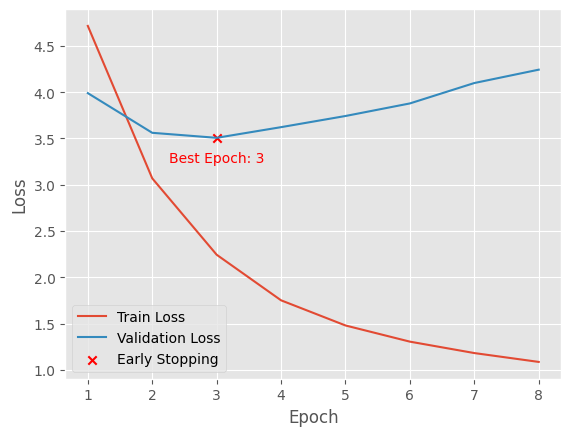

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.scatter(best_epoch + 1, val_losses[best_epoch], color='red', marker='x', label='Early Stopping')
plt.text(best_epoch + 1, val_losses[best_epoch] - 0.30, f'Best Epoch: {best_epoch + 1}',
         color='red', fontsize=10, va='bottom', ha='center')
plt.legend()
plt.show()

In [ ]:
model.load_state_dict(torch.load('model.pt'))
test_loss = evaluate(model, test_loader, criterion)
print(f'\tTest Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f}')

Evaluate: 100%|██████████| 88/88 [00:03<00:00, 27.01it/s]

	Test Loss: 3.535 | Test PPL:  34.298


## Translation Process

In [35]:
source = "السماء زرقاء"
input = preprocess(source, src_vocab)
input = input[:,None].to(torch.int64).to(device)

In [36]:
#target = torch.zeros(len(source.split(' '))+2,1,).to(torch.int64)
#target = torch.zeros(len(source.split(' ')) + 3, 1).to(torch.int64)  # Increase length slightly

target_length = len(source.split()) + 3  # +3 to give some room for additional tokens (e.g., <eos>, <bos>)

# Initialize the target tensor with the dynamically calculated length
target = torch.zeros(target_length, 1).to(torch.int64)

with torch.no_grad():
    model.eval()
    input = input.to(device)
    target = target.to(device)
    output = model(input, target, 0)
    output_dim = output.shape[-1]
    output = output[1:].view(-1, output_dim)

In [37]:
prediction = []
for i in output:
    prediction.append(torch.argmax(i).item())
tokens = trg_vocab.lookup_tokens(prediction)

In [38]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
TreebankWordDetokenizer().detokenize(tokens).replace('', "").replace('"',"").strip()

'roughly attacks prison pain'

In [39]:
# List of 20 Arabic sentences for testing
arabic_sentences = [
    "ماذا تفعل في حديقتي في منزلي؟",  # What are you doing in my garden in my house?
    "أين هو أقرب مطعم؟",  # Where is the nearest restaurant?
    "كيف حالك؟",  # How are you?
    "أنا أحب البرمجة.",  # I love programming.
    "الجو اليوم جميل.",  # The weather is nice today.
    "أين يمكنني شراء تذاكر السينما؟",  # Where can I buy movie tickets?
    "أنا ذاهب إلى السوق.",  # I am going to the market.
    "أحتاج إلى مساعدة.",  # I need help.
    "هل يمكنك مساعدتي في هذا المشروع؟",  # Can you help me with this project?
    "كم الساعة الآن؟",  # What time is it now?
    "أريد كوب من القهوة.",  # I want a cup of coffee.
    "هل يمكنك أن تعطيني الاتجاهات؟",  # Can you give me directions?
    "أنا أتعلم البرمجة.",  # I am learning programming.
    "الطعام لذيذ هنا.",  # The food is delicious here.
    "هل تعرف أين تقع المكتبة؟",  # Do you know where the library is?
    "أحتاج إلى التحدث مع المدير.",  # I need to speak with the manager.
    "كيف أصل إلى المطار؟",  # How do I get to the airport?
    "هل يمكنني دفع الفاتورة؟",  # Can I pay the bill?
    "أريد شراء هدية لصديقي.",  # I want to buy a gift for my friend.
    "أين يقع الفندق؟",  # Where is the hotel?
]

# Loop through each Arabic sentence
for sentence in arabic_sentences:
    # Preprocess the Arabic sentence
    input = preprocess(sentence, src_vocab)
    input = input[:, None].to(torch.int64).to(device)

    target_length = len(sentence.split()) + 3  # +3 for additional tokens
    target = torch.zeros(target_length, 1).to(torch.int64)

    # Model evaluation
    with torch.no_grad():
        model.eval()
        input = input.to(device)
        target = target.to(device)
        output = model(input, target, 0)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)

    # Decoding the output
    prediction = []
    for i in output:
        prediction.append(torch.argmax(i).item())
    tokens = trg_vocab.lookup_tokens(prediction)

    # Detokenizing the tokens to form the translated sentence
    translated_sentence = TreebankWordDetokenizer().detokenize(tokens).replace('', "").replace('"', "").strip()

    # Print the original Arabic sentence and its translation
    print(f"Arabic: {sentence}")
    print(f"Translated: {translated_sentence}\n")


Arabic: ماذا تفعل في حديقتي في منزلي؟
Translated: roughly attacks stones fresh robbing account alcoholics anything

Arabic: أين هو أقرب مطعم؟
Translated: roughly attacks stones worst performance complaining

Arabic: كيف حالك؟
Translated: roughly attacks prison pain

Arabic: أنا أحب البرمجة.
Translated: roughly rained duties recommend between

Arabic: الجو اليوم جميل.
Translated: roughly attacks prison pain felt

Arabic: أين يمكنني شراء تذاكر السينما؟
Translated: roughly attacks alcohol pm trading encouraged answering

Arabic: أنا ذاهب إلى السوق.
Translated: roughly attacks stones kenji putting bullet

Arabic: أحتاج إلى مساعدة.
Translated: roughly silver spoilt suddenly polar

Arabic: هل يمكنك مساعدتي في هذا المشروع؟
Translated: jack bee then incident kind contract glass strangers

Arabic: كم الساعة الآن؟
Translated: roughly jellyfish size part intention

Arabic: أريد كوب من القهوة.
Translated: roughly jellyfish solve potable exclaimed theft

Arabic: هل يمكنك أن تعطيني الاتجاهات؟
Transl